# Expectation Maximization Applied to the Old Faithful Dataset

In [1]:
import scipy.io
import numpy 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import numpy as atle
import seaborn
from scipy.stats import multivariate_normal
%matplotlib inline  

In [2]:
matlabData = scipy.io.loadmat('old_faithful.mat')
data = matlabData['data']
data = data - np.mean( data, axis=0, keepdims=True )

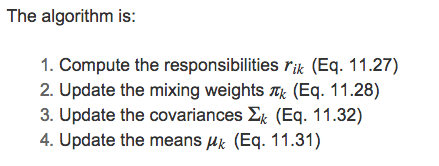

In [3]:
#Subset of Regressors Equation 
from IPython.display import Image
Image(filename='main-algorithm.png')

In [21]:
# ------------ INITIALIZE PARAMETERS ------------ #
# the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])
 
# the Gaussian covariance matrices
covs = list()
covs.append( 
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs.append( 
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )
 
# The Gaussian mixing weights
mws = [ 0.68618439, 0.31381561 ]  # called alpha in the slides

Wiks = np.zeros((len(data), 2))
# ------------ INITIALIZATION COMPLETE ------------ #

In [5]:
# STEP 1  ---> RESPONSIBILITIES
def updateResponsibilities():
    for i in range(0,len(data),1):
        #print "@@ X:", data[i]," Mus: ", mus[:,0],"Covs: ", covs[0], "**"
        #print "Covs: ", np.atleast_2d(covs).shape
        #print "data: ", data.shape
        #print "Wiks: ",  Wiks.shape
        #print "mus:  ", mus[:,0].shape
        Wiks[i,0] = multivariate_normal.pdf(data[i,:].T, mean=mus[:,0], cov=np.atleast_2d(covs[0])) * mws[0]
        Wiks[i,1] = multivariate_normal.pdf(data[i,:].T, mean=mus[:,1], cov=np.atleast_2d(covs[1])) * mws[1]
        summed = ((Wiks[i,0] * mws[0]) + (Wiks[i,1] * mws[1]) )
        normed1 = (Wiks[i,0] / summed)
        normed2 = (Wiks[i,1] / summed)
        Wiks[i,0] = normed1
        Wiks[i,1] = normed2

In [6]:
# STEP 2  ---> MIXING WEIGHTS
def updateMixingWeights(): 
    N0 = 0
    N1 = 0
    for index in range (0, len(data), 1):
        N0 += Wiks[index][0]
        N1 += Wiks[index][1]

    mw0 = (N0 / len(data))
    mw1 = (N1 / len(data))
    mws[0] = mw0
    mws[1] = mw1

In [15]:
# STEP 3  ---> COVARIANCE MATRIX
def updateCovariance(): 
    
    N0 = 0
    N1 = 0
    for index in range (0, len(data), 1):
        N0 += Wiks[index][0]
        N1 += Wiks[index][1]
    
    covariance0 = np.zeros((2, 2))
    covariance1 = np.zeros((2, 2))
    for i in range (0, len(data), 1):
        #Covariance 0
        xMinusMu = np.atleast_2d(data[i] - mus[:,0]) # NB !!! ???
        xMinusMuTranspose = xMinusMu.T  #np.transpose(xMinusMu)
        val = Wiks[i][0] * xMinusMuTranspose.dot( xMinusMu)
        covariance0 += val

        #Covariance 1
        xMinusMu = np.atleast_2d(data[i] - mus[:,1]) # NB !!! ???
        xMinusMuTranspose = xMinusMu.T  #np.transpose(xMinusMu)
        val = Wiks[i][1] * xMinusMuTranspose.dot( xMinusMu)
        covariance1 += val
    covariance0 = covariance0 / N0
    covariance1 = covariance1 / N1
    covs[0] = covariance0
    covs[1] = covariance1

In [20]:
# STEP 4  ---> MEANS
def updateMeans(): 
    
    N0 = 0
    N1 = 0
    for index in range (0, len(data), 1):
        N0 += Wiks[index][0]
        N1 += Wiks[index][1]
 
    WikXi0 = 0
    WikXi1 = 1

    #print Wiks
    #THIS NEEDS TO BE DOUBLE CHECKED
    for index in range (0,len(data), 1):
        WikXi0 += Wiks[index][0] * data[index]
        WikXi1 += Wiks[index][1] * data[index]

    mu0 = (1/N0) * WikXi0
    mu1 = (1/N1) * WikXi1

    mus[:,0] = mu0 # mus[:,0] = mu0
    mus[:,1] = mu1 # mus[:,1] = mu1

In [17]:
def graphClusters(): 
    shifted0XVals = []
    shifted0YVals = []
    shifted1XVals = []
    shifted1YVals = []
    
    cov0X, cov0Y = cov_to_pts(covs[0])
    cov1X, cov1Y = cov_to_pts(covs[1])
    for i in range(0, len(cov0X),1):
        shifted0XVals.append(cov0X[i]   + mus[0][0])
        shifted0YVals.append(cov0Y[i]   + mus[1][0])
        shifted1XVals.append(cov1X[i]   + mus[0][1])
        shifted1YVals.append(cov1Y[i]   + mus[1][1])
    
    
    cluster0Points = []
    cluster1Points = []
    #clasify points
    for i in range (0, len(data), 1):
        #print data[i]
        if Wiks[i][0] > Wiks[i][1]:
            cluster0Points.append(data[i])
        else: 
            cluster1Points.append(data[i])
            
    cluster0X = np.zeros(len(cluster0Points))
    cluster0Y = np.zeros(len(cluster0Points))
    for i in range (0, len(cluster0Points), 1):
        cluster0X[i] = cluster0Points[i][0]
        cluster0Y[i] = cluster0Points[i][1]
    
    cluster1X = np.zeros(len(cluster1Points))
    cluster1Y = np.zeros(len(cluster1Points))
    for i in range (0, len(cluster1Points), 1):
        cluster1X[i] = cluster1Points[i][0]
        cluster1Y[i] = cluster1Points[i][1]
        
    #print Mus
    # color=map(str, normalized_responsibilities[:,0])
    #plt.scatter(mus[0][0], mus[1][0], s=120, color=map(str, normalized_responsibilities[:,0]))
    #plt.scatter(mus[0][1], mus[1][1], s=120, color=map(str, normalized_responsibilities[:,0]))
    
    #Means
    plt.scatter(mus[0][0], mus[1][0], s=120, c='white')
    plt.scatter(mus[0][1], mus[1][1], s=120, c='black')
           
    print "CLUSTER 0: ", len(cluster0X)  
    print "CLUSTER 1: ", len(cluster1X)
    print "Mu 0     : ", mus[0][0], mus[1][0]
    print "Mu 1     : ", mus[0][1], mus[1][1]
     
    
    plt.scatter(cluster0X,cluster0Y, c='white')
    plt.scatter(cluster1X,cluster1Y, c='black')
        
        
    plt.plot(shifted0XVals, shifted0YVals, c='blue', label='Class 0')
    plt.plot(shifted1XVals, shifted1YVals, c='green', label='Class 1')
    plt.show()
    

In [10]:
def cluster(): 
    updateResponsibilities()
    updateMixingWeights()
    updateCovariance()
    updateMeans()
    graphClusters()

In [11]:
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

CLUSTER 0:  131
CLUSTER 1:  141
Mu 0     :  0.948909361274 8.98258022401
Mu 1     :  -0.723560931206 -6.86334770019


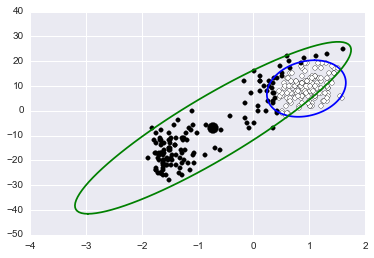

In [47]:
cluster()

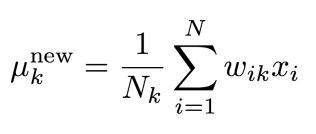

In [48]:
Image(filename='mus.png')

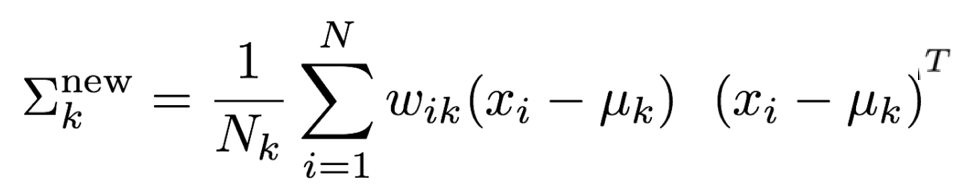

In [139]:
Image(filename='covariance.png')

# Compute Responsibilities

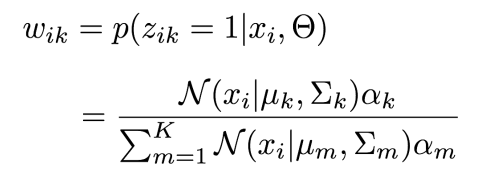

In [28]:
#to calculate everything within the conditional gaussian in the equation below, we will use this library: 
    # scipy.stats.multivariate_normal.pdf
Image(filename='responsibilities.png')

#Update Mixing Weights (pi / alpha / mws)

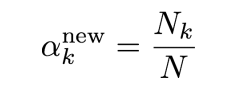

In [33]:
Image(filename='mixing-weights.png')

#Update Means (mus)